# Text Augmentation using LLM


In [33]:
!pip install transformers accelerate tqdm seaborn matplotlib imblearn -q


In [34]:
!pip install --upgrade huggingface_hub

In [35]:
from huggingface_hub import login
login()

In [36]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)



In [37]:
# Google Colab setup
# from google.colab import drive, userdata
# drive.mount('/content/drive/')
# PROJECT_DIR = userdata.get('PROJECT_DIR')

# Understanding the Data

In [38]:
# Reading the dataset
data = pd.read_csv(f'IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv', parse_dates=['Data'])
data.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [39]:
# Dataset info
data.info()

In [40]:
# Missing value count
data.isnull().sum()

,0
Unnamed: 0,0
Data,0
Countries,0
Local,0
Industry Sector,0
Accident Level,0
Potential Accident Level,0
Genre,0
Employee or Third Party,0
Critical Risk,0


In [41]:
# Dropping the index column
data.drop('Unnamed: 0', axis=1, inplace=True)

In [42]:
# Checking for duplicates
data.duplicated().sum()

7

In [43]:
# Dropping duplicates
data.drop_duplicates(inplace=True, ignore_index=True)

In [44]:
# Renaming 'Data', 'Countries', 'Genre' columns in Data frame
data.rename(columns={'Data':'Date', 'Countries':'Country', 'Genre':'Gender'}, inplace=True)
data.info()

# Data Analysis

In [45]:
# Splitting date, month and year
data['Year'] = data['Date'].apply(lambda x: x.year)
data['Month'] = data['Date'].apply(lambda x: x.month)
data['Day'] = data['Date'].apply(lambda x: x.day)

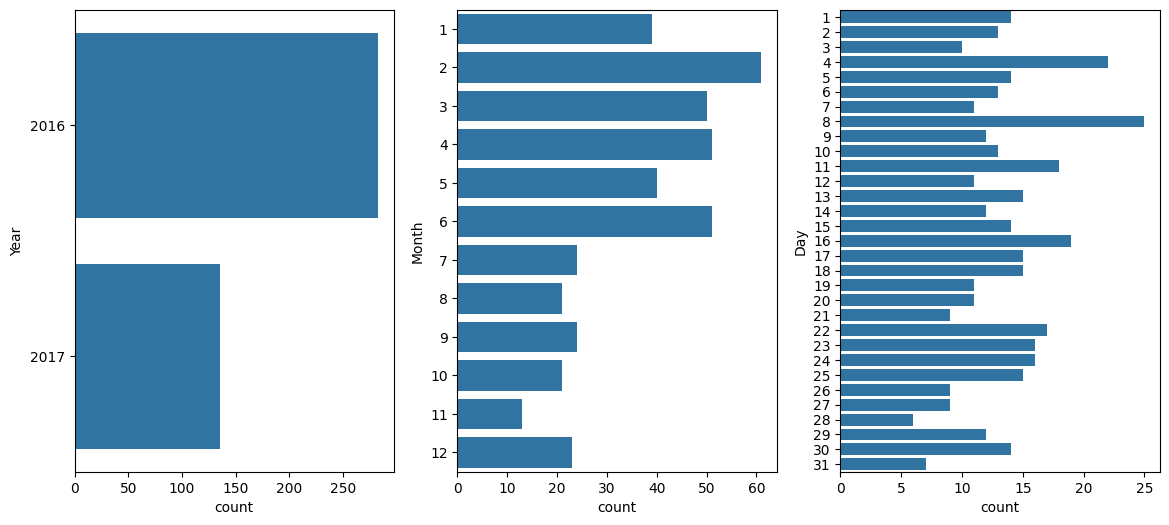

In [46]:
# Distributions
fig, ax = plt.subplots(1, 3, figsize=(14, 6))
for i, col in enumerate(['Year', 'Month', 'Day']):
    sns.countplot(y=data[col].astype('category'), ax=ax[i])

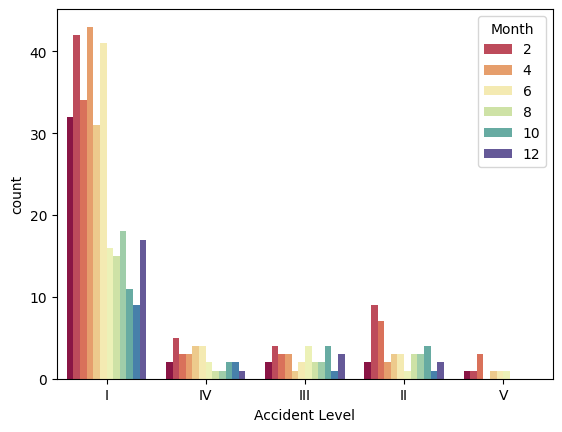

In [47]:
# Countplot
sns.countplot(data, x='Accident Level', hue='Month', palette='Spectral');

In [48]:
# Dropping datetime info
data.drop(['Date', 'Year', 'Month', 'Day'], axis=1, inplace=True)

In [49]:
def countplot(df, col=None):
    count_plot = sns.countplot(df, x=col) if col else sns.countplot(x=df)
    for bars in count_plot.containers:
        for p in bars:
            count_plot.annotate(
                f'{(100 * p.get_height() / df.shape[0]) :.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center',
                va='bottom'
            )

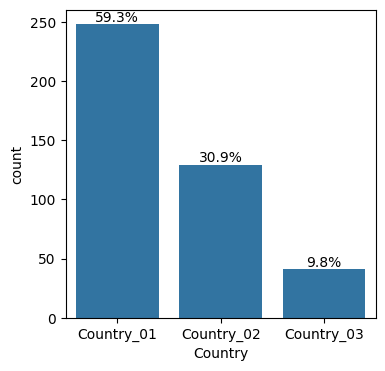

In [50]:
# Country
plt.figure(figsize=(4, 4))
countplot(data, 'Country')

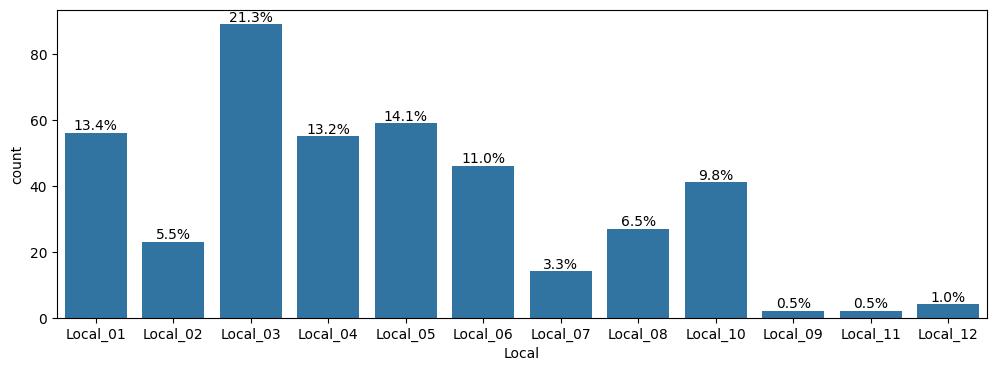

In [51]:
# Local
plt.figure(figsize=(12, 4))
countplot(data, 'Local')

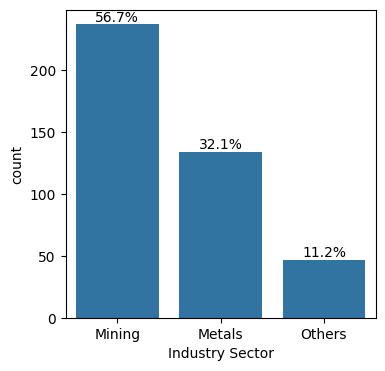

In [52]:
# Industry Sector
plt.figure(figsize=(4, 4))
countplot(data, 'Industry Sector')

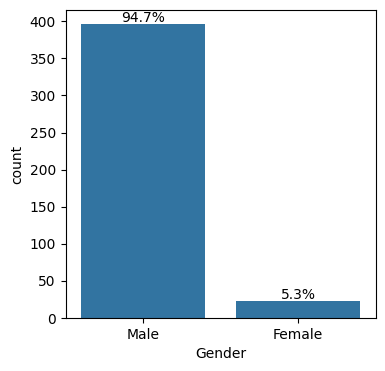

In [53]:
# Gender
plt.figure(figsize=(4, 4))
countplot(data, 'Gender')

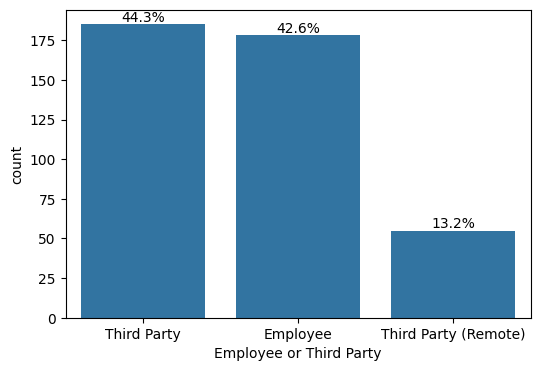

In [54]:
# Employee or Third Party
plt.figure(figsize=(6, 4))
countplot(data, 'Employee or Third Party')

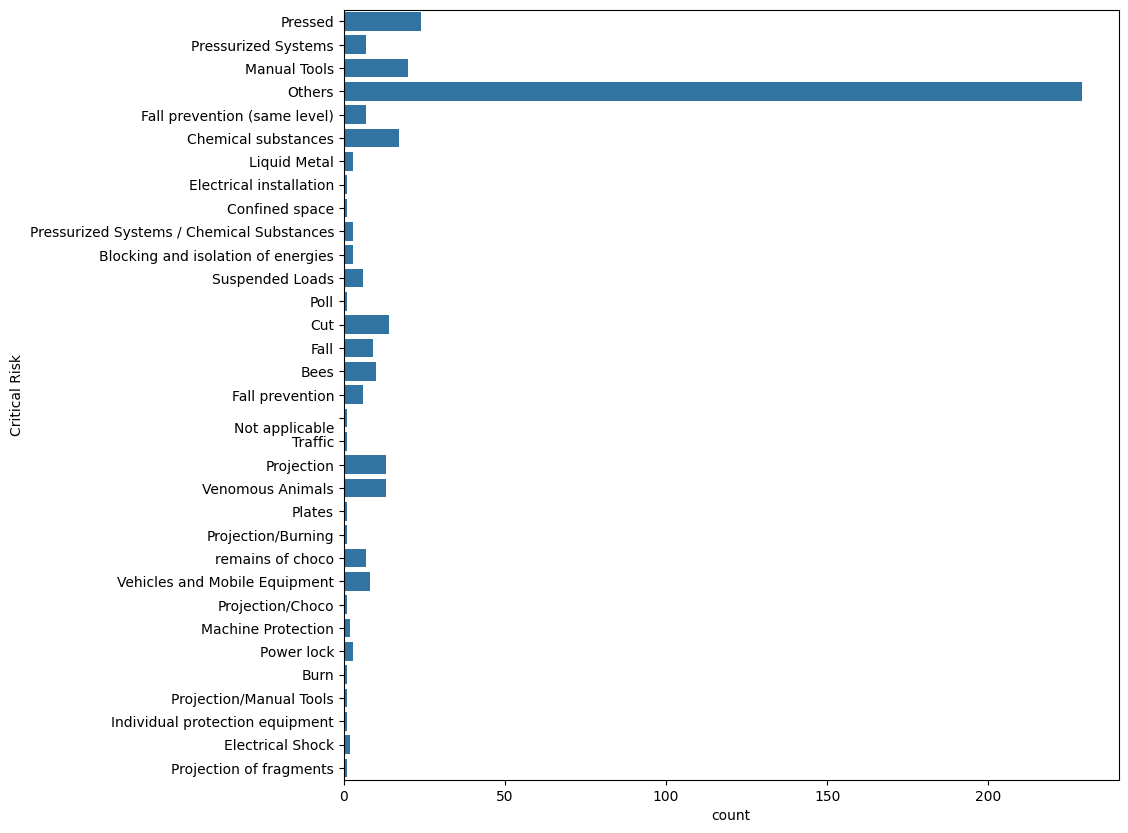

In [55]:
# Critical Risk
plt.figure(figsize=(10, 10))
sns.countplot(y=data['Critical Risk']);

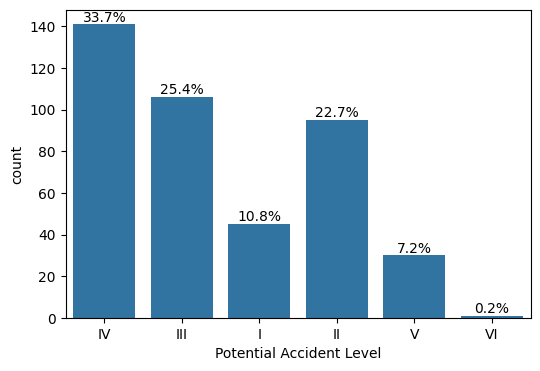

In [56]:
# Potential Accident Level
plt.figure(figsize=(6, 4))
countplot(data, 'Potential Accident Level')

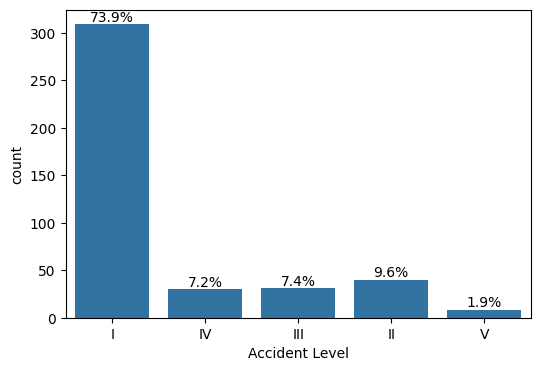

In [57]:
# Accident Level
plt.figure(figsize=(6, 4))
countplot(data, 'Accident Level')

# Categorical Encoding

In [58]:
# Label encoding
data['Gender'] = data['Gender'].apply(lambda x: {'Male': 0, 'Female': 1}[x])
data['Accident Level'] = data['Accident Level'].apply(lambda x: {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5}[x])
data['Potential Accident Level'] = data['Potential Accident Level'].apply(lambda x: {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6}[x])

data.info()

In [59]:
# One-hot encoding
data = pd.get_dummies(data, columns=['Country', 'Local', 'Industry Sector', 'Employee or Third Party', 'Critical Risk'], dtype=np.int64)
data.info()

# Data Balancing

In [60]:
from sklearn.model_selection import train_test_split

# Seperating target and predictor variables
X = data.drop(["Accident Level"], axis=1)
Y = data["Accident Level"]

# Train & test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

print('Shape of:')
print(f'Train set:', x_train.shape)
print(f'Test set:', x_test.shape)

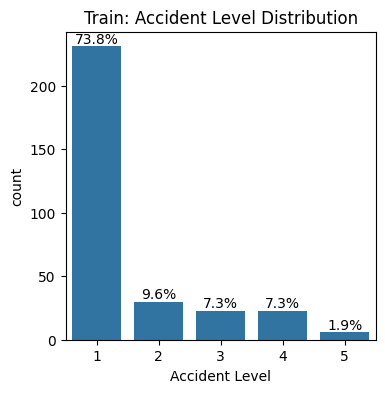

In [61]:
plt.figure(figsize=(4, 4))
countplot(y_train)
plt.title('Train: Accident Level Distribution');

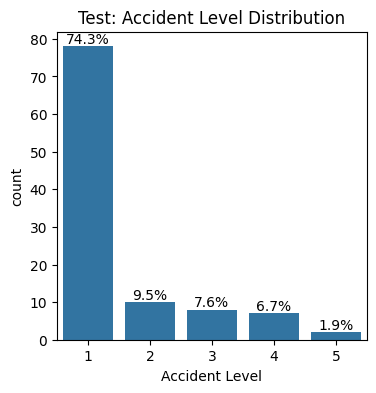

In [62]:
plt.figure(figsize=(4, 4))
countplot(y_test)
plt.title('Test: Accident Level Distribution');

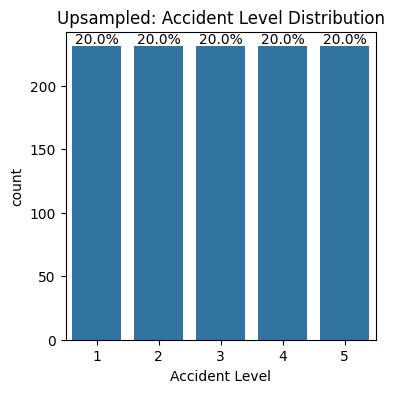

In [63]:
from imblearn.over_sampling import SMOTE

# Separating numerical and text attributes in order to appy SMOTE up-sampling
x_train_us = x_train.drop('Description', axis=1)
descriptions = x_train['Description']

smote = SMOTE(k_neighbors=5, random_state=42)
x_train_us, y_train_us = smote.fit_resample(x_train_us, y_train)

plt.figure(figsize=(4, 4))
countplot(y_train_us)
plt.title('Upsampled: Accident Level Distribution');


In [64]:
# Resampling descriptions with NaN
descriptions = pd.concat([descriptions, pd.Series([np.nan] * (x_train_us.shape[0] - x_train.shape[0]), name='Description')], ignore_index=True)

# Concatenating resampled x_train and descriptions
x_train_us = pd.concat([x_train_us, descriptions], axis=1)

x_train_us.sample(5)

,Potential Accident Level,Gender,Country_Country_01,Country_Country_02,Country_Country_03,Local_Local_01,Local_Local_02,Local_Local_03,Local_Local_04,Local_Local_05,...,Critical Risk_Projection of fragments,Critical Risk_Projection/Burning,Critical Risk_Projection/Choco,Critical Risk_Projection/Manual Tools,Critical Risk_Suspended Loads,Critical Risk_Traffic,Critical Risk_Vehicles and Mobile Equipment,Critical Risk_Venomous Animals,Critical Risk_remains of choco,Description
775,4,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
756,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
428,2,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
375,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
52,4,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"On 04/19/2017, the employee de Lima da Silva w..."


In [65]:
# Saving up-sampled sets
pd.concat([x_train_us, y_train_us], axis=1).to_csv(f'augmented_train.csv', index=False)
pd.concat([x_test, y_test], axis=1).to_csv(f'augmented_test.csv', index=False)

# Text Augmentation using LLM

In [66]:
train_us = pd.read_csv(f'augmented_train.csv')
train_us.info()

In [70]:
train_df = pd.concat([x_train, y_train], axis=1)

In [72]:
# Installing llama-cpp-python library
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python[cuda] --force-reinstall --no-cache-dir -q

In [80]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the LLaMA 3.1 model
model_name = "HuggingFaceTB/SmolLM-360M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

def generate_synthetic_description(record):
    """
    Function to replace missing Description entries with synthetically generated text.
    """
    if pd.notna(record.loc['Description']):
        return record

    # Selecting random Descriptions of the same Accident Level
    random.seed(record.name)
    accident_level = record.loc['Accident Level']
    subset = train_df[train_df['Accident Level'] == accident_level]
    samples = subset.sample(3)['Description'].tolist()

    # Generate text using the LLM
    input_text = f"Consider the following descriptions of an industrial accident that represent a severity level of {accident_level} out of 6:\n1. {samples[0]}\n2. {samples[1]}\n3. {samples[2]}\n Generate a new description of an industrial accident with similar severity."
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

    outputs = model.generate(inputs["input_ids"], max_new_tokens=400, temperature=0.9)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    record.loc['Description'] = generated_text
    return record

# Apply the synthetic text generation to the dataset
train_us = train_us.progress_apply(generate_synthetic_description, axis=1)

# Save the augmented training dataset with synthetic descriptions
train_us.to_csv(f'augmented_train.csv', index=False)

# Print dataset information after augmentation
train_us.info()

# Preview the synthetic descriptions
train_us[['Description']].tail(10)


100%|██████████| 1155/1155 [00:00<00:00, 17362.71it/s]


,Description
1145,Consider the following descriptions of an indu...
1146,Consider the following descriptions of an indu...
1147,Consider the following descriptions of an indu...
1148,Consider the following descriptions of an indu...
1149,Consider the following descriptions of an indu...
1150,Consider the following descriptions of an indu...
1151,Consider the following descriptions of an indu...
1152,Consider the following descriptions of an indu...
1153,Consider the following descriptions of an indu...
1154,Consider the following descriptions of an indu...


In [81]:
# Testing the function generate_synthetic_description
list(train_us.tail(5).progress_apply(generate_synthetic_description, axis=1)['Description'])

100%|██████████| 5/5 [00:00<00:00, 810.27it/s]


['Consider the following descriptions of an industrial accident that represent a severity level of 5 out of 6:\n1. During the activity of changing conveyor belt 11B feeding the primary mill No. 2; the mechanic entered the discharge chute (0.75 x 0.75 x 0.80 m.) to clean the material, at which time the automatic sampler (0.30 x 0.25 m) that was inside the chute was activated, trapping the mechanic at the height of the chest. At the time of the accident the mechanic was alone in the work area.\n2. When performing shotcrete casting for resane on Cruise 791 Nv. 1940 at 02:50 p.m. approximately, the operator was placed on the left side of the equipment and started the release of 02 cubic meters, at that time decided to paralyze the task for a few minutes due to a leak of water in the roof box that did not allow the adhesion of the shotcrete to the rock (setting). When restarting the shotcrete launch the operator that was on the left side moved to the right side of the equipment, while the a

In [82]:
# Text up-sampling
train_us = train_us.progress_apply(generate_synthetic_description, axis=1)
train_us.to_csv(f'augmented_train.csv', index=False)
train_us.info()

100%|██████████| 1155/1155 [00:00<00:00, 16078.50it/s]
